In [42]:
import numpy as np
from astropy.table import Table, vstack, Column, hstack
from astropy.coordinates import SkyCoord
from astropy.io import fits
import astropy.units as u
import numpy.random as rd
import matplotlib.pyplot as plt
from astropy.cosmology import FlatLambdaCDM
from scipy.special import gamma, gammaincc
from statsmodels.stats.weightstats import DescrStatsW
from astropy.constants import c, G, M_sun
from matplotlib.ticker import StrMethodFormatter, MultipleLocator, NullLocator, FixedLocator
import matplotlib.patches as mpatches
from matplotlib.patches import PathPatch
from matplotlib.path import Path
from scipy.stats import ks_2samp
from matplotlib.legend_handler import HandlerLineCollection, HandlerTuple
from astropy.io import fits
from scipy.optimize import curve_fit
import math,random
import seaborn as sns

cos = FlatLambdaCDM(H0=100, Om0=0.27)

In [5]:
# VAGC Image Data: http://sdss.physics.nyu.edu/vagc-dr7/vagc2/
ima = Table.read('../object_sdss_imaging.fits')
ima = ima['RA','DEC','PETROFLUX','EXTINCTION']
imt = SkyCoord(ima['RA'], ima['DEC'], unit=(u.deg, u.deg))
ima['rmag'] = 22.5 - 2.5*np.log10(ima['PETROFLUX'].T[2]) - ima['EXTINCTION'].T[2]

/var/folders/8k/p6qnzbn934jd2z75vwrs1j2h0000gn/T/ipykernel_49251/1634982063.py:5: RuntimeWarning: invalid value encountered in log10
  ima['rmag'] = 22.5 - 2.5*np.log10(ima['PETROFLUX'].T[2]) - ima['EXTINCTION'].T[2]


In [6]:
# Smallest Enclosed Circle: https://www.nayuki.io/page/smallest-enclosing-circle
def make_circle(points):
    shuffled = [(float(p[0]), float(p[1])) for p in points]
    random.shuffle(shuffled)
    c = None
    for (i, p) in enumerate(shuffled):
        if c is None or not _is_in_circle(c, p):
            c = _make_circle_one_point(shuffled[0 : i + 1], p)
    return c

def _make_circle_one_point(points, p):
    c = (p[0], p[1], 0.0)
    for (i, q) in enumerate(points):
        if not _is_in_circle(c, q):
            if c[2] == 0.0:
                c = _make_diameter(p, q)
            else:
                c = _make_circle_two_points(points[0 : i + 1], p, q)
    return c

def _make_circle_two_points(points, p, q):
    diameter = _make_diameter(p, q)
    if all(_is_in_circle(diameter, r) for r in points):
        return diameter
    left = None
    right = None
    for r in points:
        cross = _cross_product(p[0], p[1], q[0], q[1], r[0], r[1])
        c = _make_circumcircle(p, q, r)
        if c is None:
            continue
        elif cross > 0.0 and (left is None or _cross_product(p[0], p[1], q[0], q[1], c[0], c[1]) > _cross_product(p[0], p[1], q[0], q[1], left[0], left[1])):
            left = c
        elif cross < 0.0 and (right is None or _cross_product(p[0], p[1], q[0], q[1], c[0], c[1]) < _cross_product(p[0], p[1], q[0], q[1], right[0], right[1])):
            right = c
    return left if (right is None or (left is not None and left[2] <= right[2])) else right

def _make_circumcircle(p0, p1, p2):
    ax = p0[0]; ay = p0[1]
    bx = p1[0]; by = p1[1]
    cx = p2[0]; cy = p2[1]
    d = (ax * (by - cy) + bx * (cy - ay) + cx * (ay - by)) * 2.0
    if d == 0.0:
        return None
    x = ((ax * ax + ay * ay) * (by - cy) + (bx * bx + by * by) * (cy - ay) + (cx * cx + cy * cy) * (ay - by)) / d
    y = ((ax * ax + ay * ay) * (cx - bx) + (bx * bx + by * by) * (ax - cx) + (cx * cx + cy * cy) * (bx - ax)) / d
    return (x, y, math.hypot(x - ax, y - ay))

def _make_diameter(p0, p1):
    return ((p0[0] + p1[0])/2.0, (p0[1] + p1[1]) / 2.0, math.hypot(p0[0] - p1[0], p0[1] - p1[1]) / 2.0)

_EPSILON = 1e-12

def _is_in_circle(c, p):
    return c is not None and math.hypot(p[0] - c[0], p[1] - c[1]) < c[2] + _EPSILON

def _cross_product(x0, y0, x1, y1, x2, y2):
    return (x1 - x0) * (y2 - y0) - (y1 - y0) * (x2 - x0)

def trans_coord(RA, DEC):
    RAn = RA - RA[0]
    if max(RAn) - min(RAn) > 358:
        RAn = (RA + 180) % 360 - (RA[0] + 180) % 360
    DECn = DEC
    theta = (90 - DEC)*np.pi/180.0
    thetatemp = np.arccos(np.cos(theta)*np.cos(-theta[0]) - np.sin(theta)*np.cos(RAn*np.pi/180.0)*np.sin(-theta[0]) - 1e-15)
    phitemp = np.arccos((np.cos(theta)*np.sin(-theta[0]) + np.sin(theta)*np.cos(RAn*np.pi/180.0)*np.cos(-theta[0]))/(np.sin(thetatemp)+1e-30)) * RAn/(abs(RAn)+1e-30)
    projX = thetatemp*np.cos(phitemp)
    projY = thetatemp*np.sin(phitemp)
    point = []
    for j in range(len(RA)):
        point.append([projX[j],projY[j]])
    return point,RA[0],DEC[0]

def trans_back(x, y, RA0, DEC0):
    theta0 = (90 - DEC0)*np.pi/180.0
    centerthetatemp = np.sqrt(x**2 + y**2)
    centerphitemp = np.arccos(x/centerthetatemp)
    center_theta = np.arccos(- 1e-15 + np.cos(centerthetatemp)*np.cos(-theta0) + np.sin(centerthetatemp)*np.cos(centerphitemp)*np.sin(-theta0))
    center_phi = np.arccos(- 1e-15 + (- np.cos(centerthetatemp)*np.sin(-theta0) + np.sin(centerthetatemp)*np.cos(centerphitemp)*np.cos(-theta0))/(np.sin(center_theta)+1e-30)) * y/(abs(y)+1e-30)
    center_dec = 90 - center_theta*180.0/np.pi
    center_ra = (center_phi*180.0/np.pi + RA0)%360
    return center_ra,center_dec

def lumweighted_coord(RA, DEC, LW):
    xl = np.cos(RA/180.*np.pi)*np.sin(np.pi/2-DEC/180.*np.pi)
    yl = np.sin(RA/180.*np.pi)*np.sin(np.pi/2-DEC/180.*np.pi)
    zl = np.cos(np.pi/2-DEC/180.*np.pi)
    xlweightedmean = np.average(xl,weights=LW)
    ylweightedmean = np.average(yl,weights=LW)
    zlweightedmean = np.average(zl,weights=LW)
    rsqmean = np.sqrt(xlweightedmean**2+ylweightedmean**2+zlweightedmean**2)
    adec = 90. - np.arccos(zlweightedmean/rsqmean)*180./np.pi
    if ylweightedmean > 0:
        ara = np.arccos(xlweightedmean/(rsqmean*np.sin(np.pi/2-adec/180.*np.pi)))*180./np.pi
    else:
        ara = 360 - np.arccos(xlweightedmean/(rsqmean*np.sin(np.pi/2-adec/180.*np.pi)))*180./np.pi
    return ara,adec

def gapper_estimate(tableZ, redshift_col, Verr_col):
    tableZ.sort(redshift_col)
    mem = len(tableZ)
    ztemp = np.mean(tableZ[redshift_col])
    dis = 0
    for j in range(mem-1):
        dis += (j+1)*(mem-j-1)*c.to('km/s').value*(tableZ[redshift_col][j+1]-tableZ[redshift_col][j])
    disV = np.sqrt(np.pi)/((1+ztemp)*mem*(mem-1))*dis
    D_i = 2*np.arange(1,mem+1,1)-(mem+1)
    diff_LOS = np.sqrt(np.pi)*c.to('km/s').value/(mem-1)*(-D_i*tableZ[redshift_col]/((np.sum(tableZ[redshift_col])+mem)**2)+D_i/(np.sum(tableZ[redshift_col])+mem))
    err_sq = np.sum((tableZ[Verr_col])**2)/mem
    return disV, np.sqrt(err_sq)

def surface_brightness(mag, R):
    rdel = 18 - np.array(mag)
    lumsig = np.power(10, rdel/2.5)
    lumtemp = np.sum(lumsig)
    surface = 18 - 2.5*math.log(lumtemp, 10) + 2.5*math.log(np.pi*3600*3600*(R + 1e-30)*(R + 1e-30), 10)
    return surface

In [9]:
grp_V1 = fits.open('../CGsV1.fits')
ccgg1 = Table(grp_V1[1].data)
pcgg1 = Table(grp_V1[2].data)
ccgg2 = Table.read('../cCGsV2.fits')

In [11]:
mem_V1 = fits.open('../cg_m_V1.fits')
ccgm1 = Table(mem_V1[1].data)
pcgm1 = Table(mem_V1[2].data)
ccgm2 = Table.read('../ccgs_m_V2.fits')

In [12]:
ccgm1t = SkyCoord(ccgm1['RAJ2000'], ccgm1['DEJ2000'], unit=(u.deg, u.deg))
ccgm2t = SkyCoord(ccgm2['R.A.'], ccgm2['Dec.'], unit=(u.deg, u.deg))
pcgm1t = SkyCoord(pcgm1['RAJ2000'], pcgm1['DEJ2000'], unit=(u.deg, u.deg))

In [14]:
idxc1, d2dc1, d3dc1 = ccgm1t.match_to_catalog_sky(imt)
idxc2, d2dc2, d3dc2 = ccgm2t.match_to_catalog_sky(imt)
idxp1, d2dp1, d3dp1 = pcgm1t.match_to_catalog_sky(imt)

# Basic Check

In [16]:
np.max(ccgm1['rmag'].data/ima['rmag'][idxc1].data), np.min(ccgm1['rmag'].data/ima['rmag'][idxc1].data),

(1.0000346, 0.9999652)

In [15]:
np.max(ccgm2['rmag'].data/ima['rmag'][idxc2].data), np.min(ccgm2['rmag'].data/ima['rmag'][idxc2].data),

(1.0000345521187708, 0.9999652195360144)

In [17]:
np.max(pcgm1['rmag'].data/ima['rmag'][idxp1].data), np.min(pcgm1['rmag'].data/ima['rmag'][idxp1].data), 

(1.0000349, 0.99996465)

In [18]:
ccgg1['mu_check'] = np.zeros(len(ccgg1))
ccgg2['mu_check'] = np.zeros(len(ccgg2))
pcgg1['mu_check'] = np.zeros(len(pcgg1))

In [19]:
for i in range(len(ccgg1)):
    gid = ccgg1['ID'][i]
    mid = np.where(ccgm1['ID']==gid)[0]
    RA, DEC = ima['RA'][idxc1[mid]].data, ima['DEC'][idxc1[mid]].data
    mags = ima['rmag'][idxc1[mid]].data
    point,RA0,DEC0 = trans_coord(RA, DEC)
    x,y,r = make_circle(point)
    center_ra,center_dec = trans_back(x, y, RA0, DEC0)
    R = r*180/np.pi
    ccgg1['mu_check'][i] = surface_brightness(mags, R)

In [20]:
for i in range(len(ccgg2)):
    gid = ccgg2['Group_ID'][i]
    mid = np.where(ccgm2['Group_ID']==gid)[0]
    RA, DEC = ima['RA'][idxc2[mid]].data, ima['DEC'][idxc2[mid]].data
    mags = ima['rmag'][idxc2[mid]].data
    point,RA0,DEC0 = trans_coord(RA, DEC)
    x,y,r = make_circle(point)
    center_ra,center_dec = trans_back(x, y, RA0, DEC0)
    R = r*180/np.pi
    ccgg2['mu_check'][i] = surface_brightness(mags, R)

In [25]:
np.max(ccgg1['mu_check']/ccgg1['mu']), np.min(ccgg1['mu_check']/ccgg1['mu']), np.sum(ccgg1['mu_check']/ccgg1['mu']<0.998)

(1.0015232635914706, 0.9870027919008604, 2)

In [27]:
ccgg1[ccgg1['mu_check']/ccgg1['mu']<0.998]

recno,ID,Nb,RAJ2000,DEJ2000,N,zg,Rad,mu,sig,Delm3,mu_check
int32,str9,int16,float64,float64,uint8,float32,float32,float32,float32,float32,float64
6088,cCGs-6088,0,210.92929999999998,8.7892,3,0.11583,0.665,25.338,753.995,1.0,25.08433851894757
6094,cCGs-6094,0,237.64869999999996,26.305499999999995,3,0.14597,0.27,22.541,327.208,1.0,22.24803029368851


In [28]:
np.max(ccgg2['mu_check']/ccgg2['mu']), np.min(ccgg2['mu_check']/ccgg2['mu'])

(1.0015232450736145, 0.9986156334442018)

In [31]:
ccgg2[(ccgg2['Group_ID']=='cCGs-6088')|(ccgg2['Group_ID']=='cCGs-6094')]

Group_ID,RAJ2000,DEJ2000,N,N+b,zg,Rad,mu,sig_gap,sig_LOS,Delm3,CrCase,CrY07PetroC,borders,Mdyn,e_Mdyn,e_sig,CrL195,Crsig_gap,Crsig_LOS,Cre_sig,Lcorr,L195,mu_check
bytes21,float64,float64,int64,int64,float64,float64,float64,float64,float64,float64,bytes21,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
cCGs-6088,210.9307,8.8077,3,3,0.11583,0.592,25.085,753.995,924.631,1.0,multiple,-99,2.0,13.587,0.52,0.26,0.0,0.0,0.0,0.0,10.679,0.0,25.08433851894757
cCGs-6094,237.6487,26.3061,3,3,0.14597,0.235,22.248,327.67,390.046,1.0,predominant,11206,2.0,0.0,0.0,0.26,11.498,0.0,0.0,0.0,11.285,0.0,22.24803029368851


In [34]:
for i in range(len(pcgg1)):
    gid = pcgg1['ID'][i]
    mid = np.where((pcgm1['ID']==gid)&(pcgm1['Gal']>0))[0]
    RA, DEC = ima['RA'][idxp1[mid]].data, ima['DEC'][idxp1[mid]].data
    mags = ima['rmag'][idxp1[mid]].data
    point,RA0,DEC0 = trans_coord(RA, DEC)
    x,y,r = make_circle(point)
    center_ra,center_dec = trans_back(x, y, RA0, DEC0)
    R = r*180/np.pi
    pcgg1['mu_check'][i] = surface_brightness(mags, R)

In [35]:
np.max(pcgg1['mu_check']/pcgg1['mu']), np.min(pcgg1['mu_check']/pcgg1['mu'])

(1.0003011603632141, 0.9998515134718171)

# Basic Statistics

(18.0, 26.0)

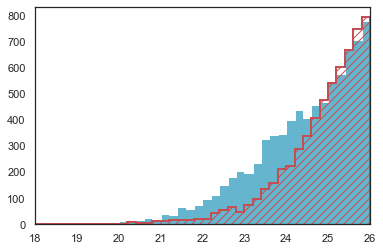

In [62]:
sns.set_theme(palette='deep',style='white')
plt.hist(ccgg2['mu'], np.arange(16,26.1,0.2), color='r', histtype='step', lw=2, hatch='///')
plt.hist(pcgg1['mu'], np.arange(16,26.1,0.2), color='c', histtype='stepfilled')
plt.xlim(18,26)

(0.0, 0.2)

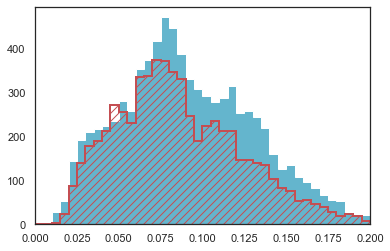

In [61]:
plt.hist(ccgg2['zg'], np.arange(0,0.21,0.005), color='r', histtype='step', lw=2, hatch='///')
plt.hist(pcgg1['zg'], np.arange(0,0.21,0.005), color='c', histtype='stepfilled')
plt.xlim(0,0.2)